# Lasso Regression

Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10

Defining input array with angles between 70 deg and 310 deg converted in radians

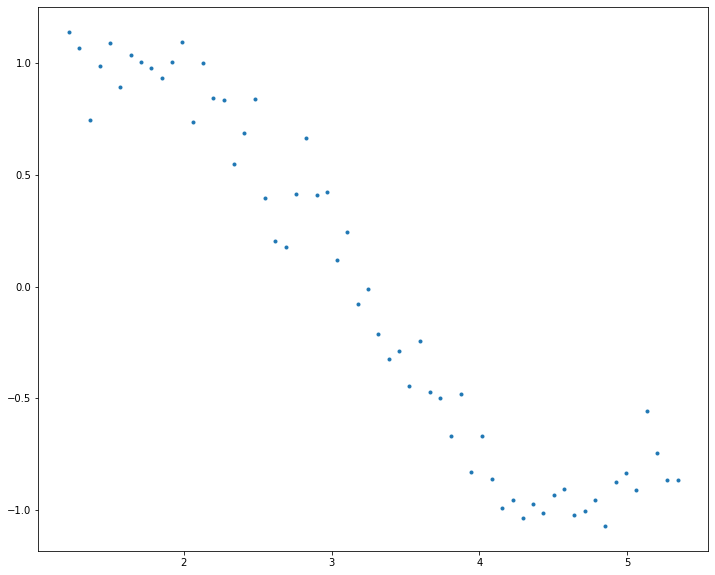

In [4]:
x = np.array([i*np.pi/180 for i in range(70,310,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios in this article. Let’s try to estimate the sine function using polynomial regression with powers of x from 1 to 15. Let’s add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [5]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2  ...        x_13        x_14        x_15
0  1.221730  1.139431  1.492625  ...   13.510776   16.506527   20.166527
1  1.291544  1.068554  1.668085  ...   27.823908   35.935792   46.412644
2  1.361357  0.746338  1.853292  ...   55.161442   75.094406  102.230281
3  1.431170  0.989010  2.048248  ...  105.678310  151.243626  216.455338
4  1.500983  1.090764  2.252950  ...  196.284337  294.619483  442.218882

[5 rows x 16 columns]


Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [6]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models. Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code


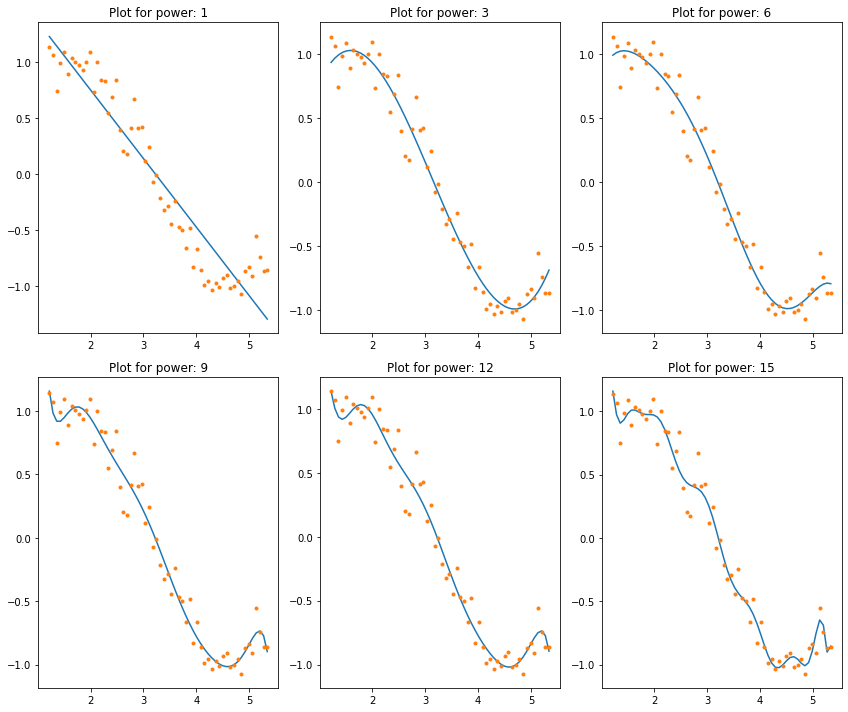

In [7]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)
    

As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [8]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple.head

<bound method NDFrame.head of               rss intercept coef_x_1  ... coef_x_13 coef_x_14 coef_x_15
model_pow_1   3.6         2    -0.61  ...       NaN       NaN       NaN
model_pow_2   3.2       2.5    -0.99  ...       NaN       NaN       NaN
model_pow_3   1.1      -1.1      3.1  ...       NaN       NaN       NaN
model_pow_4   1.1     -0.51      2.1  ...       NaN       NaN       NaN
model_pow_5     1       4.1     -6.7  ...       NaN       NaN       NaN
model_pow_6  0.99      -4.6       13  ...       NaN       NaN       NaN
model_pow_7  0.93        32      -85  ...       NaN       NaN       NaN
model_pow_8  0.92        74 -2.1e+02  ...       NaN       NaN       NaN
model_pow_9  0.87   3.1e+02   -1e+03  ...       NaN       NaN       NaN
model_pow_10 0.87   2.5e+02   -8e+02  ...       NaN       NaN       NaN
model_pow_11 0.87  -2.2e+02  1.2e+03  ...       NaN       NaN       NaN
model_pow_12 0.87  -8.4e+02  4.1e+03  ...       NaN       NaN       NaN
model_pow_13 0.86   8.1e+03 -4.1e+

LASSO stands for Least Absolute Shrinkage and Selection Operator. I know it doesn’t give much of an idea but there are 2 key words here – ‘absolute‘ and ‘selection‘.

Lets consider the former first and worry about the latter later.

Lasso regression performs L1 regularization, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

1. α = 0: Same coefficients as simple linear regression
2. α = ∞: All coefficients zero (same logic as before)
3. 0 < α < ∞: coefficients between 0 and that of simple linear regression

Yes its appearing to be very similar to Ridge till now. But just hang on with me and you’ll know the difference by the time we finish. Like before, lets run lasso regression on the same problem as above. First we’ll define a generic function:

In [11]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Notice the additional parameters defined in Lasso function – ‘max_iter‘. This is the maximum number of iterations for which we want the model to run if it doesn’t converge before. This exists for Ridge as as well but setting this to a higher than default value was required in this case. Why? I’ll come to this in next section, just keep it in the back of the envelope.

Lets check the output for 10 different values of alpha using the following code:

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47932662214355404, tolerance: 0.0036604711033743015
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47926307180099476, tolerance: 0.0036604711033743015
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4729613975883399, tolerance: 0.0036604711033743015
  positive)


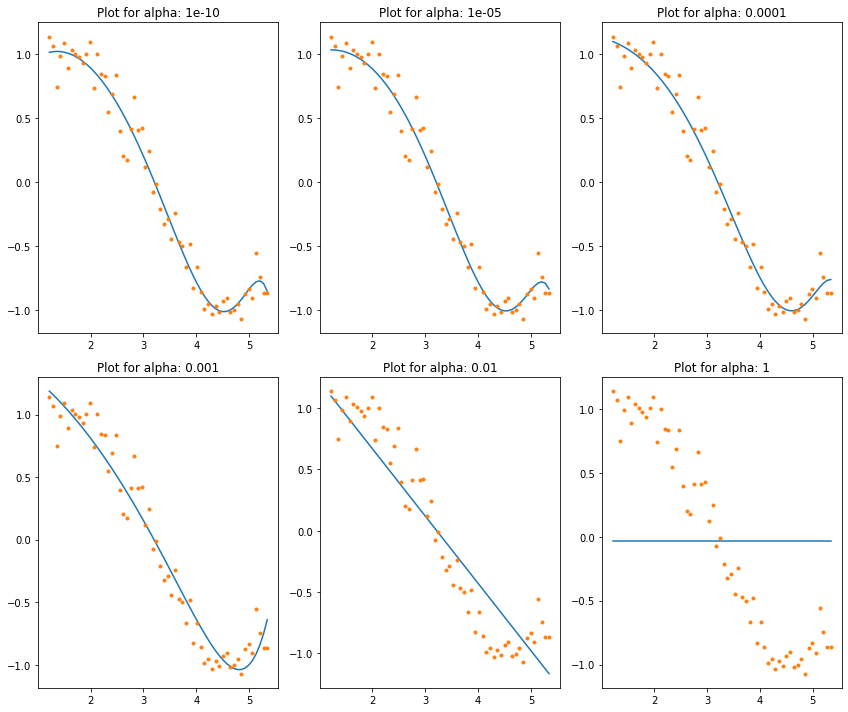

In [12]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

This again tells us that the model complexity decreases with increase in the values of alpha. But notice the straight line at alpha=1. Appears a bit strange to me. Let’s explore this further by looking at the coefficients:

In [14]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso.head

<bound method NDFrame.head of               rss intercept coef_x_1  ... coef_x_13 coef_x_14 coef_x_15
alpha_1e-15  0.96      0.38     0.96  ...   1.6e-10  -1.2e-10  -5.8e-11
alpha_1e-10  0.96      0.38     0.96  ...   1.6e-10  -1.2e-10  -5.8e-11
alpha_1e-08  0.96      0.38     0.96  ...   1.7e-10  -1.2e-10  -5.8e-11
alpha_1e-05  0.96      0.77     0.39  ...         0        -0  -4.3e-11
alpha_0.0001    1       1.2        0  ...        -0        -0  -2.7e-11
alpha_0.001   1.6       1.5    -0.16  ...         0         0         0
alpha_0.01    3.9       1.8    -0.55  ...         0         0         0
alpha_1        37    -0.034       -0  ...        -0        -0        -0
alpha_5        37    -0.034       -0  ...        -0        -0        -0
alpha_10       37    -0.034       -0  ...        -0        -0        -0

[10 rows x 17 columns]>

Apart from the expected inference of higher RSS for higher alphas, we can see the following:

1. For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).
2. For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression
3. Many of the coefficients are zero even for very small values of alpha

Inferences #1,2 might not generalize always but will hold for many cases. T
he real difference from ridge is coming out in the last inference. Lets check the number of coefficients which are zero in each model using following code:

In [15]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    11
alpha_0.001     11
alpha_0.01      14
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

We can observe that **even for a small value of alpha, a significant number of coefficients are zero.** This also explains the horizontal line fit for alpha=1 in the lasso plots, its just a baseline model! This phenomenon of most of the coefficients being zero is called **‘sparsity‘**. Although lasso performs feature selection, this level of sparsity is achieved in special cases only which we’ll discuss towards the end.


This has some really interesting implications on the use cases of lasso regression as compared to that of ridge regression. But before coming to the final comparison, lets take a **bird’s eye view** of the mathematics behind why coefficients are zero in case of lasso but not ridge.